## Connect to database and read in data

In [1]:
import psycopg2

In [2]:
con = psycopg2.connect(user = "postgres",
                       password = "",
                       host = "127.0.0.1",
                       port = "5432",
                       database = "adj_noun_pairs")

try:
    cursor = con.cursor();
except (Exception, psycopg2.Error) as error:
    print("Error in Connection",error)

In [3]:
try:
    cursor.execute("SELECT * FROM pair_counts_10000 WHERE noun IN (SELECT noun FROM pair_counts_10000 GROUP BY noun HAVING COUNT(*) >= 5) AND count >= 3;")
    pairs = cursor.fetchall() 
except (Exception, psycopg2.Error) as error:
    con.rollback()
    print("Error while inserting data into the table:", error)

In [4]:
len(pairs)

29112

In [5]:
adjs = list(set([pair[0] for pair in pairs]))
nouns = list(set([pair[1] for pair in pairs]))

In [6]:
print(len(nouns), len(adjs))

4373 3152


In [7]:
import pandas as pd
import numpy as np

In [8]:
df = pd.DataFrame(0, index=nouns, columns=adjs)
df.head()

,hüpotekaarne,vääriv,lühike,tegelnud,entsefaliidijärgne,tõusev,kokkuleppeline,tervislik,purjus,võiv,...,kumer,aromaatne,ealine,pärilik,kingitud,tasane,tossav,eelajalooline,halvustav,graniitne
optimism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
siluett,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
valuutafond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
käändevorm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
õiguskord,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for tup in pairs:
    df.loc[tup[1], tup[0]] = tup[2]
    
df.head()

,hüpotekaarne,vääriv,lühike,tegelnud,entsefaliidijärgne,tõusev,kokkuleppeline,tervislik,purjus,võiv,...,kumer,aromaatne,ealine,pärilik,kingitud,tasane,tossav,eelajalooline,halvustav,graniitne
optimism,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
siluett,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
valuutafond,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
käändevorm,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
õiguskord,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## LDA model creation and training

In [10]:
from sklearn.decomposition import LatentDirichletAllocation

In [12]:
lda = LatentDirichletAllocation(n_components=500, random_state=1)
lda_topics = lda.fit_transform(df)
lda_topics.shape

(4373, 500)

## Euclidean distances from topics

In [18]:
from collections import defaultdict
import itertools
import time
from datetime import timedelta, datetime

In [16]:
ids = list(range(len(nouns)))
id_pairs = list(itertools.combinations(ids, 2))

In [19]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

lda_similarities = defaultdict(dict)

for pair in id_pairs:
    first = pair[0]
    second = pair[1]
    dist = np.linalg.norm(lda_topics[first] - lda_topics[second]) # euclidean distance
    
    lda_similarities[first][second] = dist
    lda_similarities[second][first] = dist
    
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

2:53:17.367597
2:56:26.300596
0:03:08.933452


In [20]:
noun_sim_df = pd.DataFrame(lda_similarities)
noun_sim_df = noun_sim_df.reindex(sorted(noun_sim_df.columns), axis=1)
noun_sim_df = noun_sim_df.reindex(sorted(noun_sim_df.index), axis=0)
noun_sim_df = noun_sim_df.fillna(0)

## t-SNE on distance matrix

In [21]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import matplotlib.patheffects as PathEffects
%matplotlib inline

In [22]:
print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
start = datetime.now()

lda_tsne = TSNE(random_state=17)
lda_tsne_results = lda_tsne.fit_transform(noun_sim_df.values)

print(str(timedelta(seconds=time.time()+7200)).split(", ")[1])
print(datetime.now()-start)

2:56:42.567024
3:00:49.918521
0:04:07.352999


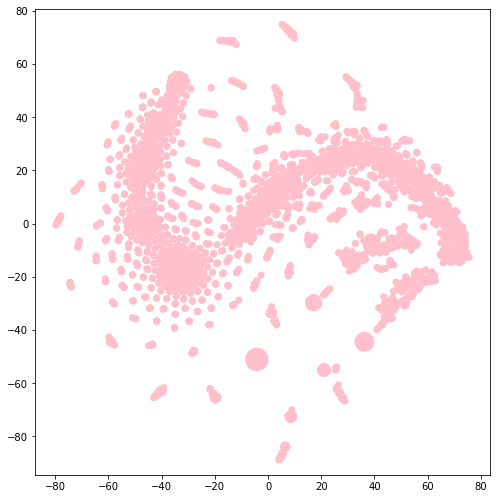

In [23]:
plt.figure(figsize=(7, 7))
plt.scatter(lda_tsne_results[:, 0], lda_tsne_results[:, 1], marker='o', s=50, edgecolor='None', c='pink')

plt.tight_layout()
plt.axis('equal')
plt.show()